In [1]:
import numpy as np
import pandas as pd
import sys
from tensorflow.keras import utils # utils.to_categorical 원핫인코딩
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from matplotlib import pyplot as plt

# 로지스틱회귀분석(이진분류)
## 1. 데이터셋 생성 & 전처리

In [2]:
df = pd.read_csv('data/pima-indians-diabetes.csv',
                 comment='#',
                 header=None)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       768 non-null    int64  
 1   1       768 non-null    int64  
 2   2       768 non-null    int64  
 3   3       768 non-null    int64  
 4   4       768 non-null    int64  
 5   5       768 non-null    float64
 6   6       768 non-null    float64
 7   7       768 non-null    int64  
 8   8       768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [3]:
# 타겟 변수의 균형
df.iloc[:,-1].value_counts()

0    500
1    268
Name: 8, dtype: int64

In [4]:
df.head()

,0,1,2,3,4,5,6,7,8
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [5]:
# csv 파일을 numpy로 읽어오기 : np.loadtxt(결측치가 없는 경우), np.genfromtxt(결측치 있을 경우)
dataset = np.loadtxt('data/pima-indians-diabetes.csv', encoding='utf-8', delimiter=',')
dataset.shape

(768, 9)

In [17]:
# 데이터분할 : 학습데이터셋(모델학습용)+시험데이터셋(모델평가용)
X_train = dataset[:700, :-1]
y_train = dataset[:700, -1]
X_test  = dataset[700:, :-1]
y_test  = dataset[700:, -1]
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((700, 8), (700,), (68, 8), (68,))

# 2. 모델 구성

In [18]:
model = Sequential()
model.add(Input(shape=(8,)))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=16, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 32)                288       
                                                                 
 dense_5 (Dense)             (None, 16)                528       
                                                                 
 dense_6 (Dense)             (None, 1)                 17        
                                                                 
Total params: 833
Trainable params: 833
Non-trainable params: 0
_________________________________________________________________


# 3. 학습과정 설정

In [19]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['binary_accuracy'])

# 4. 학습

In [20]:
%%time
hist = model.fit(X_train, y_train, # 훈련데이터
                 epochs=200, # 학습횟수
                 batch_size=350, # 한번에 읽어들이는 데이터 양
                #  validation_data=[X_test,y_test] # 검증데이터
                #  validation_split=0.1,
                 verbose=0 # 학습 로그 출력 0:출력안됨, 2:상세출력
                 )

CPU times: total: 1.55 s
Wall time: 1.31 s


# 5.모델 평가하기(학습과정 보기, 평가, 혼동행렬)

In [21]:
hist.history.keys()

dict_keys(['loss', 'binary_accuracy'])

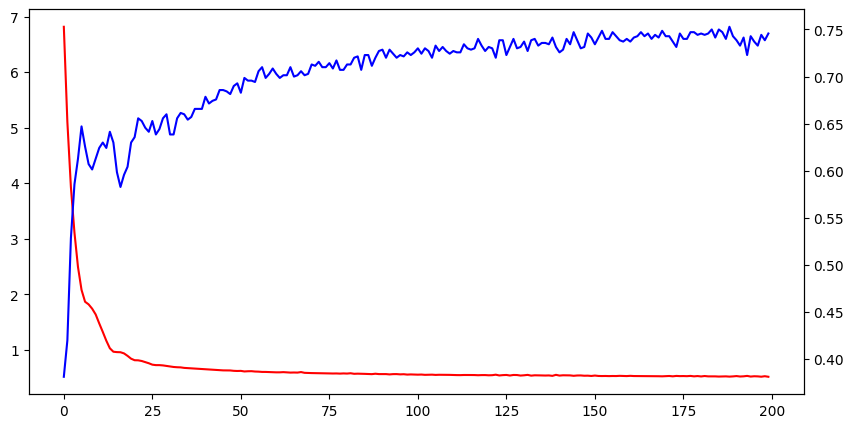

In [24]:
# 학습과정 표시(학습데이터에 대한 loss와 accuracy)
fig, loss_ax = plt.subplots(figsize=(10,5))
loss_ax.plot(hist.history['loss'], 'r')
acc_ax = loss_ax.twinx() # loss_ax와 x축을 공유하는 acc_ax
acc_ax.plot(hist.history.get('binary_accuracy'), 'b')

In [25]:
# 모델 평가(X)
model.evaluate(X_train, y_train)

22/22 [==============================] - 0s 2ms/step - loss: 0.5241 - binary_accuracy: 0.7300


[0.5240518450737, 0.7300000190734863]

In [26]:
# 모델 평가(O)
model.evaluate(X_test, y_test)

3/3 [==============================] - 0s 3ms/step - loss: 0.6642 - binary_accuracy: 0.6912


[0.6642212867736816, 0.6911764740943909]

## 혼동행렬
- 테스트 데이터 셋의 실제값과 예측값으로 작성된 교차표

In [32]:
# 실제값 : y_test (68개)
# 예측값 : X_test
y_hat = (model.predict(X_test)>=0.5).astype(float)
y_hat[:5]

3/3 [==============================] - 0s 2ms/step


array([[0.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [34]:
TN = 0 # 0을 0으로 예측한 경우(T)
FP = 0 # 0을 1로 예측한 경우(F)
FN = 0 # 1을 0으로 예측한 경우의 수(F)
TP = 0 # 1을 1로 예측한 경우의 수(T)
print(y_test.shape, y_hat.shape)
for y, h in zip(y_test, y_hat.reshape(-1)):
    if y==0 and h==0:
        TN += 1
    elif y==0 and h==1:
        FP += 1
    elif y==1 and h==0:
        FN += 1
    else:
        TP += 1
print(TN, FP)
print(FN, TP)

(68,) (68, 1)
39 2
19 8


In [38]:
ctab = pd.crosstab(y_test,          # 실제값
                   y_hat.reshape(-1))   # 예측값
ctab.index.name = '실제값'
ctab.columns.name = '예측값'
ctab
pd.crosstab(y_test,          # 실제값
            y_hat.reshape(-1),
            rownames=['실제값'],
            colnames=['예측값'])   # 예측값

예측값,0.0,1.0
실제값,,
0.0,39,2
1.0,19,8


In [39]:
# 혼동행렬
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,
                y_hat.reshape(-1))

array([[39,  2],
       [19,  8]], dtype=int64)

In [40]:
# accuracy
print('accuracy :', (TN+TP)/(TN+FP+FN+TP))
print('recall :', TP / (FP+TP) )
print('precision :', TP / (FN+TP))      

accuracy : 0.6911764705882353
recall : 0.8
precision : 0.2962962962962963


# 6. 모델사용

In [41]:
X_test[0]

array([  2.   , 122.   ,  76.   ,  27.   , 200.   ,  35.9  ,   0.483,
        26.   ])

In [44]:
int(model.predict(np.array([[2. , 122. ,76. ,27. , 200. ,35.9, 0.483, 26. ]]))>=0.5)

1/1 [==============================] - 0s 31ms/step


0

In [45]:
model.predict(np.array([[2. , 122. ,76. ,27. , 200. ,35.9, 0.483, 26. ],
                         [0 , 122. ,76. ,27. , 200. ,35.9, 0.483, 26. ]])).astype(int)

1/1 [==============================] - 0s 104ms/step


array([[0],
       [0]])

# 분류분석
1. 데이터셋 생성 및 전처리 : 훈련셋(600), 검증셋(100개), 테스트셋(68)
2. 모델 생성(input8, output 2) : 출력층 softmax(출력합을 1)
    * model.summary() 파라미터 수와 메모리 확인
3. 모델 학습과정 설정 : loss='categorical_crossentropy, metrics=['accuracy']
4. 모델 학습 : 훈련셋과 검증셋
5. 모델 평가 : 그래프(hist.history), 평가(테스트셋), 교차표(테스트셋)
6. 모델 저장 및 사용 : predict결과에 argmax()
 [99.2, 0.8]

# 1. 데이터 셋 생성 및 전처리

In [48]:
dataset = np.loadtxt('data/pima-indians-diabetes.csv',
                     encoding='utf-8',
                     delimiter=',')
dataset.shape

(768, 9)

In [52]:
# 훈련셋(600), 검증셋(100개), 테스트셋(68)
X_train = dataset[:600, :-1]
y_train = dataset[:600, -1]
X_val = dataset[600:700, :-1]
y_val = dataset[600:700, -1]
X_test = dataset[700:, :-1]
y_test = dataset[700:, -1]
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((600, 8), (600,), (100, 8), (100,), (68, 8), (68,))

In [63]:
# 타겟변수의 원핫인코딩 (분류분석)
print(y_train[:5])
print(utils.to_categorical(y_train[:5]))
Y_train = utils.to_categorical(y_train)
Y_val = utils.to_categorical(y_val)
Y_test = utils.to_categorical(y_test)
Y_train.shape, y_train.shape, Y_val.shape, Y_test.shape

[1. 0. 1. 0. 1.]
[[0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]]


((600, 2), (600,), (100, 2), (68, 2))

# 2. 모델 생성(input8, target2)
- 과적합 줄이는 단계 추가

In [64]:
model = Sequential()
model.add(Input(shape=(8,)))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=16, activation='relu'))
model.add(Dense(units=8, activation='relu'))
model.add(Dense(units=2, activation='softmax'))
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_17 (Dense)            (None, 32)                288       
                                                                 
 dense_18 (Dense)            (None, 64)                2112      
                                                                 
 dense_19 (Dense)            (None, 16)                1040      
                                                                 
 dense_20 (Dense)            (None, 8)                 136       
                                                                 
 dense_21 (Dense)            (None, 2)                 18        
                                                                 
Total params: 3,594
Trainable params: 3,594
Non-trainable params: 0
_________________________________________________________________


# 3. 학습과정 설정

In [65]:
model.compile(loss='categorical_crossentropy',
              optimizer='nadam',
              metrics=['accuracy'])

In [66]:
hist = model.fit(X_train, Y_train,
                 epochs=500,
                 validation_data=(X_val,Y_val),
                 verbose=1,
                 )

Epoch 1/500
19/19 [==============================] - 1s 16ms/step - loss: 0.8302 - accuracy: 0.6350 - val_loss: 0.7462 - val_accuracy: 0.6500
Epoch 2/500
19/19 [==============================] - 0s 4ms/step - loss: 0.7078 - accuracy: 0.6633 - val_loss: 0.9922 - val_accuracy: 0.5500
Epoch 3/500
19/19 [==============================] - 0s 4ms/step - loss: 0.6727 - accuracy: 0.6650 - val_loss: 0.6416 - val_accuracy: 0.6900
Epoch 4/500
19/19 [==============================] - 0s 4ms/step - loss: 0.6561 - accuracy: 0.6850 - val_loss: 0.6399 - val_accuracy: 0.6200
Epoch 5/500
19/19 [==============================] - 0s 4ms/step - loss: 0.6303 - accuracy: 0.7000 - val_loss: 0.6789 - val_accuracy: 0.6700
Epoch 6/500
19/19 [==============================] - 0s 4ms/step - loss: 0.5978 - accuracy: 0.6967 - val_loss: 0.7057 - val_accuracy: 0.5800
Epoch 7/500
19/19 [==============================] - 0s 4ms/step - loss: 0.6010 - accuracy: 0.6967 - val_loss: 0.7135 - val_accuracy: 0.6700
Epoch 8/500


# 5. 학습과정 살펴보기

In [62]:
hist.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

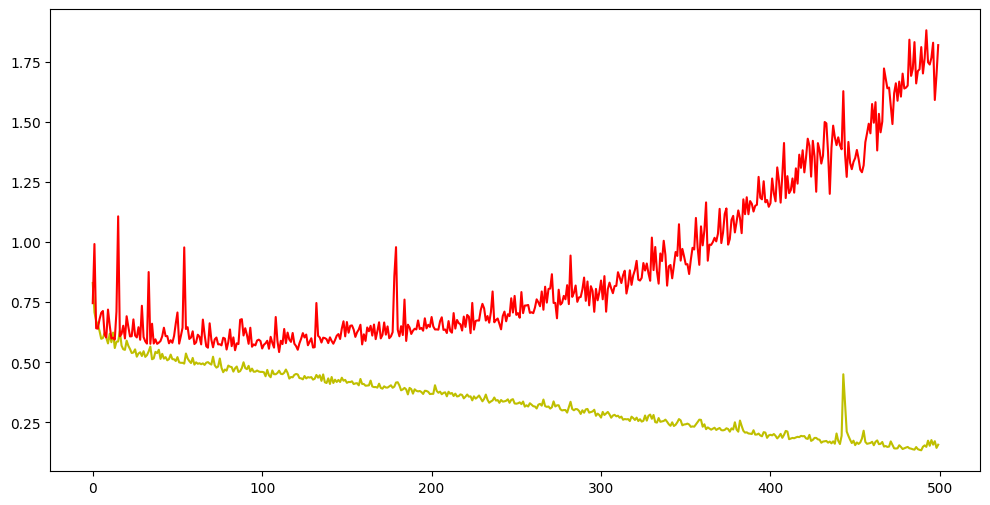

In [67]:
fig, loss_ax = plt.subplots(figsize=(12,6))
loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')